Una vez que creamos el primer dataset, vamos a dividirlo en train y test, tratar los valores nulos y outliers y hacer el shift para tener nuestros datos listos para ser usados por un modelo

In [23]:
#vamos a leer foundational_dataset.csv y definir el y 
import pandas as pd
df_final=pd.read_csv("foundational_dataset.csv")

#quiero ordenar los datos segun FECHA_HORA
df_final["FECHA_HORA"] = pd.to_datetime(
    df_final["FECHA_HORA"].astype(str),  # asegúrate de que los datos sean strings
    errors="coerce",      # marca inválidos como NaT
    # format="..."        # si conoces el formato exacto, mejor especificarlo
)
df_final = df_final.sort_values("FECHA_HORA", ascending=True, na_position="last")

df_final["FECHA_HORA"]

0     2020-07-01 23:59:00
1     2020-07-02 23:59:00
2     2020-07-03 23:59:00
3     2020-07-04 23:59:00
4     2020-07-05 23:59:00
              ...        
954   2023-03-01 23:59:00
955   2023-03-02 23:59:00
956   2023-03-03 23:59:00
957   2023-03-04 23:59:00
958   2023-03-05 23:59:00
Name: FECHA_HORA, Length: 959, dtype: datetime64[ns]

In [24]:
df_final["Frio_diff1_lag1"] = df_final["Frio (Kw)"].astype(float).diff().shift(1)
df_final["Frio_diff7_lag1"] = df_final["Frio (Kw)"].astype(float).diff().shift(1)
roll_windows = [3, 7, 14,28]
for window in roll_windows:
    df_final[f"Frio_roll_mean_{window}_lag1"] = df_final["Frio (Kw)"].astype(float).shift(1).rolling(window=window).mean()
    df_final[f"Frio_roll_std_{window}_lag1"] = df_final["Frio (Kw)"].astype(float).shift(1).rolling(window=window).std()

y = df_final["Frio (Kw)"].shift(-1)  # predecir el siguiente valor de Frio (Kw)

In [25]:
y.dropna(inplace=True)
X = df_final.loc[y.index]

In [26]:
X

,FECHA_HORA,EE Planta / Hl,EE Elaboracion / Hl,EE Bodega / Hl,EE Cocina / Hl,EE Envasado / Hl,EE Linea 2 / Hl,EE Linea 3 / Hl,EE Linea 4 / Hl,EE Servicios / Hl,...,Frio_diff1_lag1,Frio_diff7_lag1,Frio_roll_mean_3_lag1,Frio_roll_std_3_lag1,Frio_roll_mean_7_lag1,Frio_roll_std_7_lag1,Frio_roll_mean_14_lag1,Frio_roll_std_14_lag1,Frio_roll_mean_28_lag1,Frio_roll_std_28_lag1
0,2020-07-01 23:59:00,642.727209,47.145349,69.023256,0.000000,13.813953,14.578784,0.000000,0.000000,554.604651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-07-02 23:59:00,7.767254,0.769609,0.798838,0.319229,2.358593,4.158962,1.506838,1.521823,5.429388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-07-03 23:59:00,8.801205,0.862593,0.835762,0.260924,1.985462,39.076667,1.448962,1.500923,5.703346,...,9629.000000,9629.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-07-04 23:59:00,5.175639,0.439225,0.371077,0.258048,1.442114,4.348182,1.355238,1.536507,3.058399,...,4314.000000,4314.000000,22182.333333,7138.341147,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-07-05 23:59:00,7.924665,0.802365,0.717787,0.301592,1.664726,5.125920,2.704348,1.471990,5.094301,...,-4022.000000,-4022.000000,25489.333333,2410.820884,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,2023-02-28 23:59:00,5.771037,0.764416,0.585371,0.313305,1.560490,4.493845,1.536465,1.513804,3.056305,...,-3781.000000,-3781.000000,18126.000000,2250.100220,18942.571429,2104.955966,18097.714286,2628.882021,18390.892857,2510.380838
954,2023-03-01 23:59:00,6.960582,0.907813,0.715616,0.356634,1.829548,4.289280,1.696989,1.547479,3.765249,...,6225.666667,6225.666667,18866.555556,3136.645808,19700.809524,2010.878589,18494.261905,2737.873035,18531.130952,2586.413840
955,2023-03-02 23:59:00,9.307652,1.326883,1.062212,0.323571,1.221995,7.212923,9.078431,2.206813,6.167811,...,1690.333333,1690.333333,20244.888889,4168.916890,20144.666667,2466.715450,18930.904762,3012.302250,18533.488095,2591.023465
956,2023-03-03 23:59:00,10.349507,1.383240,1.289095,0.360673,0.524170,16.664444,NaN,9.750000,7.930706,...,-4591.000000,-4591.000000,21353.222222,2321.937944,19882.952381,2496.467530,18919.190476,3012.248005,18467.738095,2557.226902


In [27]:

import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


# Calcular el punto de corte (10% más antiguo = test)
n_test = int(len(df_final) * 0.10)
n_train = len(df_final) - n_test

# Split temporal

x_test = X.iloc[n_train:].copy()
x_train = X.iloc[:n_train].copy()
y_test = y.iloc[n_train:].copy()
y_train = y.iloc[:n_train].copy()
print(f"\nTrain: {len(x_train)} registros ({len(x_train)/len(df_final)*100:.1f}%)")
print(f"  Fechas: {x_train['FECHA_HORA'].min()} a {x_train['FECHA_HORA'].max()}")
print(f"\nTest: {len(x_test)} registros ({len(x_test)/len(df_final)*100:.1f}%)")
print(f"  Fechas: {x_test['FECHA_HORA'].min()} a {x_test['FECHA_HORA'].max()}")







Train: 864 registros (90.1%)
  Fechas: 2020-07-01 23:59:00 a 2022-11-29 23:59:00

Test: 94 registros (9.8%)
  Fechas: 2022-11-30 23:59:00 a 2023-03-04 23:59:00


In [28]:
x_train.drop(columns=["FECHA_HORA"], inplace=True)
x_test.drop(columns=["FECHA_HORA"], inplace=True)

In [29]:
# DETECCIÓN DE OUTLIERS CON LOCAL OUTLIER FACTOR

# Guardar datos originales
X_train_original = x_train.copy()

X_test_original = x_test.copy()

#vamos a estandarizar los datos antes de aplicar LOF
scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


# Seleccionar solo columnas numéricas para LOF
numeric_cols = x_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nColumnas numéricas para LOF: {len(numeric_cols) / len(x_train.columns)*100:.2f}% ({len(numeric_cols)} columnas)")

# Manejar NaN antes de LOF (LOF no acepta NaN)
train_for_lof = x_train_scaled[numeric_cols].fillna(x_train_scaled[numeric_cols].median())
test_for_lof = x_test_scaled[numeric_cols].fillna(x_train_scaled[numeric_cols].median())

# Ajustar LOF en train
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
train_outliers = lof.fit_predict(train_for_lof)

# Aplicar LOF en test (usando fit de train)
# LOF no tiene predict, usamos fit_predict con novelty=True
lof_novelty = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
lof_novelty.fit(train_for_lof)
test_outliers = lof_novelty.predict(test_for_lof)

# Contar outliers (-1 = outlier, 1 = inlier)
n_train_outliers = (train_outliers == -1).sum()
n_test_outliers = (test_outliers == -1).sum()

print(f"\nOutliers detectados en TRAIN: {n_train_outliers} ({n_train_outliers/len(train)*100:.2f}%)")
print(f"Outliers detectados en TEST: {n_test_outliers} ({n_test_outliers/len(test)*100:.2f}%)")

# Marcar outliers como NaN en TODAS las columnas numéricas
train_with_outliers = x_train.copy()
test_with_outliers = x_test.copy()

for col in numeric_cols:
    train_with_outliers.loc[train_outliers == -1, col] = np.nan
    test_with_outliers.loc[test_outliers == -1, col] = np.nan

print(f"\n✓ Outliers marcados como NaN")
print(f"  Train - NaN totales: {train_with_outliers.isna().sum().sum()}")
print(f"  Test - NaN totales: {test_with_outliers.isna().sum().sum()}")



Columnas numéricas para LOF: 100.00% (140 columnas)

Outliers detectados en TRAIN: 44 (5.09%)
Outliers detectados en TEST: 6 (6.32%)

✓ Outliers marcados como NaN
  Train - NaN totales: 9841
  Test - NaN totales: 1820


c:\Users\agusm\Trabajo-Final-Lab-Datos-\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [30]:

# IMPUTACIÓN CON KNN REGRESSOR
print("\n" + "=" * 80)
print("4. IMPUTACIÓN DE VALORES NULOS CON KNN")
print("=" * 80)

# Contar NaN antes de imputación
print(f"\nNaN antes de imputación:")
print(f"  Train: {train_with_outliers[numeric_cols].isna().sum().sum()}")
print(f"  Test: {test_with_outliers[numeric_cols].isna().sum().sum()}")

# Configurar KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

# Ajustar en train e imputar
train_imputed_numeric = knn_imputer.fit_transform(train_with_outliers[numeric_cols])
train_imputed = train_with_outliers.copy()
train_imputed[numeric_cols] = train_imputed_numeric

# Aplicar en test
test_imputed_numeric = knn_imputer.transform(test_with_outliers[numeric_cols])
test_imputed = test_with_outliers.copy()
test_imputed[numeric_cols] = test_imputed_numeric

print(f"\n✓ Imputación completada")
print(f"  Train - NaN restantes: {train_imputed.isna().sum().sum()}")
print(f"  Test - NaN restantes: {test_imputed.isna().sum().sum()}")




def descargar_dataframe_como_csv(df, nombre_archivo):
    try:
        df.to_csv(nombre_archivo, index=False)
        print(f"✅ Archivo '{nombre_archivo}' guardado correctamente.")
    except Exception as e:
        print(f"❌ Ocurrió un error al guardar el archivo: {e}")

descargar_dataframe_como_csv(train_imputed, "x_train.csv")
descargar_dataframe_como_csv(test_imputed, "x_val.csv")
descargar_dataframe_como_csv(y_train.to_frame(), "y_train.csv")
descargar_dataframe_como_csv(y_test.to_frame(), "y_val.csv")



4. IMPUTACIÓN DE VALORES NULOS CON KNN

NaN antes de imputación:
  Train: 9841
  Test: 1820

✓ Imputación completada
  Train - NaN restantes: 0
  Test - NaN restantes: 0
✅ Archivo 'x_train.csv' guardado correctamente.
✅ Archivo 'x_val.csv' guardado correctamente.
✅ Archivo 'y_train.csv' guardado correctamente.
✅ Archivo 'y_val.csv' guardado correctamente.


1. ESTADÍSTICAS DESCRIPTIVAS - TRAIN

Estadísticas básicas:
       EE Linea 3 / Hl  EE Frio / Hl  EE Resto Serv / Hl  Agua Linea 3/Hl  \
count           864.00        864.00              864.00           864.00   
mean              1.65          3.38                0.73             1.33   
std               2.22         11.44                1.93             2.15   
min               0.00          0.00               -3.55             0.00   
25%               1.36          2.27                0.43             0.88   
50%               1.63          2.71                0.58             1.21   
75%               1.91          3.38                0.75             1.54   
max              39.75        333.14               52.12            50.91   

       ET Linea 3/Hl  Hl de Mosto  Hl Cerveza Cocina  Hl Producido Bodega  \
count         864.00       864.00             864.00               864.00   
mean           14.07      5833.25            9215.72              9141.45   
std            

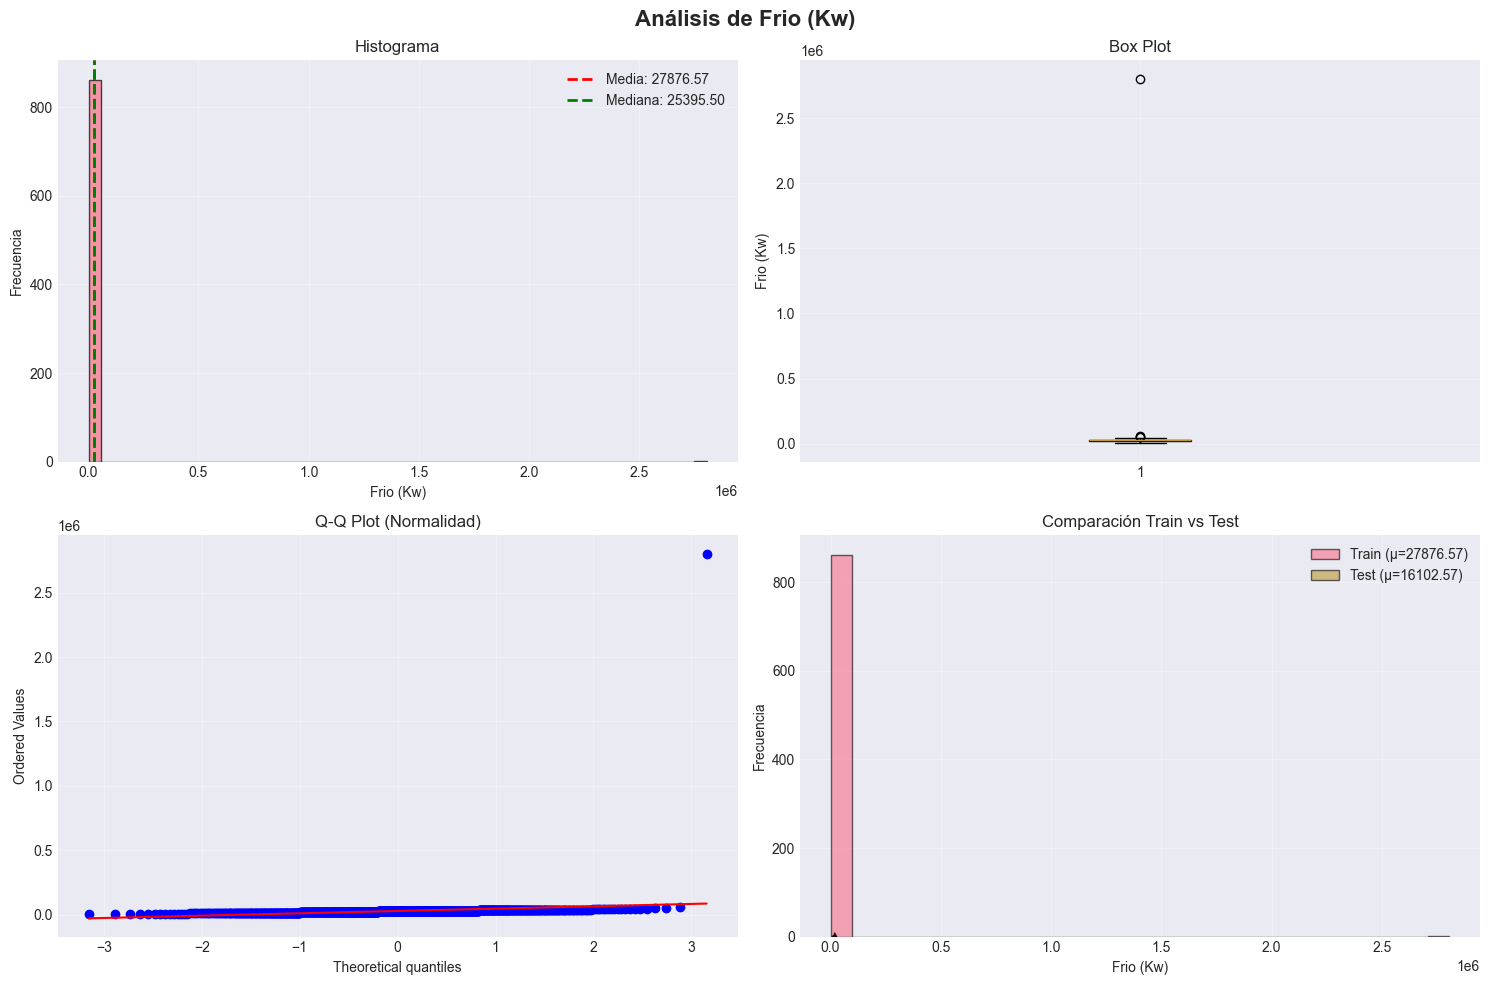


Estadísticas de Frio (Kw):
  Media: 27876.57
  Mediana: 25395.50
  Desv. Std: 94904.76
  Min: 2310.00
  Max: 2804229.00
  Skewness: 29.08
  Kurtosis: 851.57

3. DISTRIBUCIÓN DE VARIABLES NUMÉRICAS


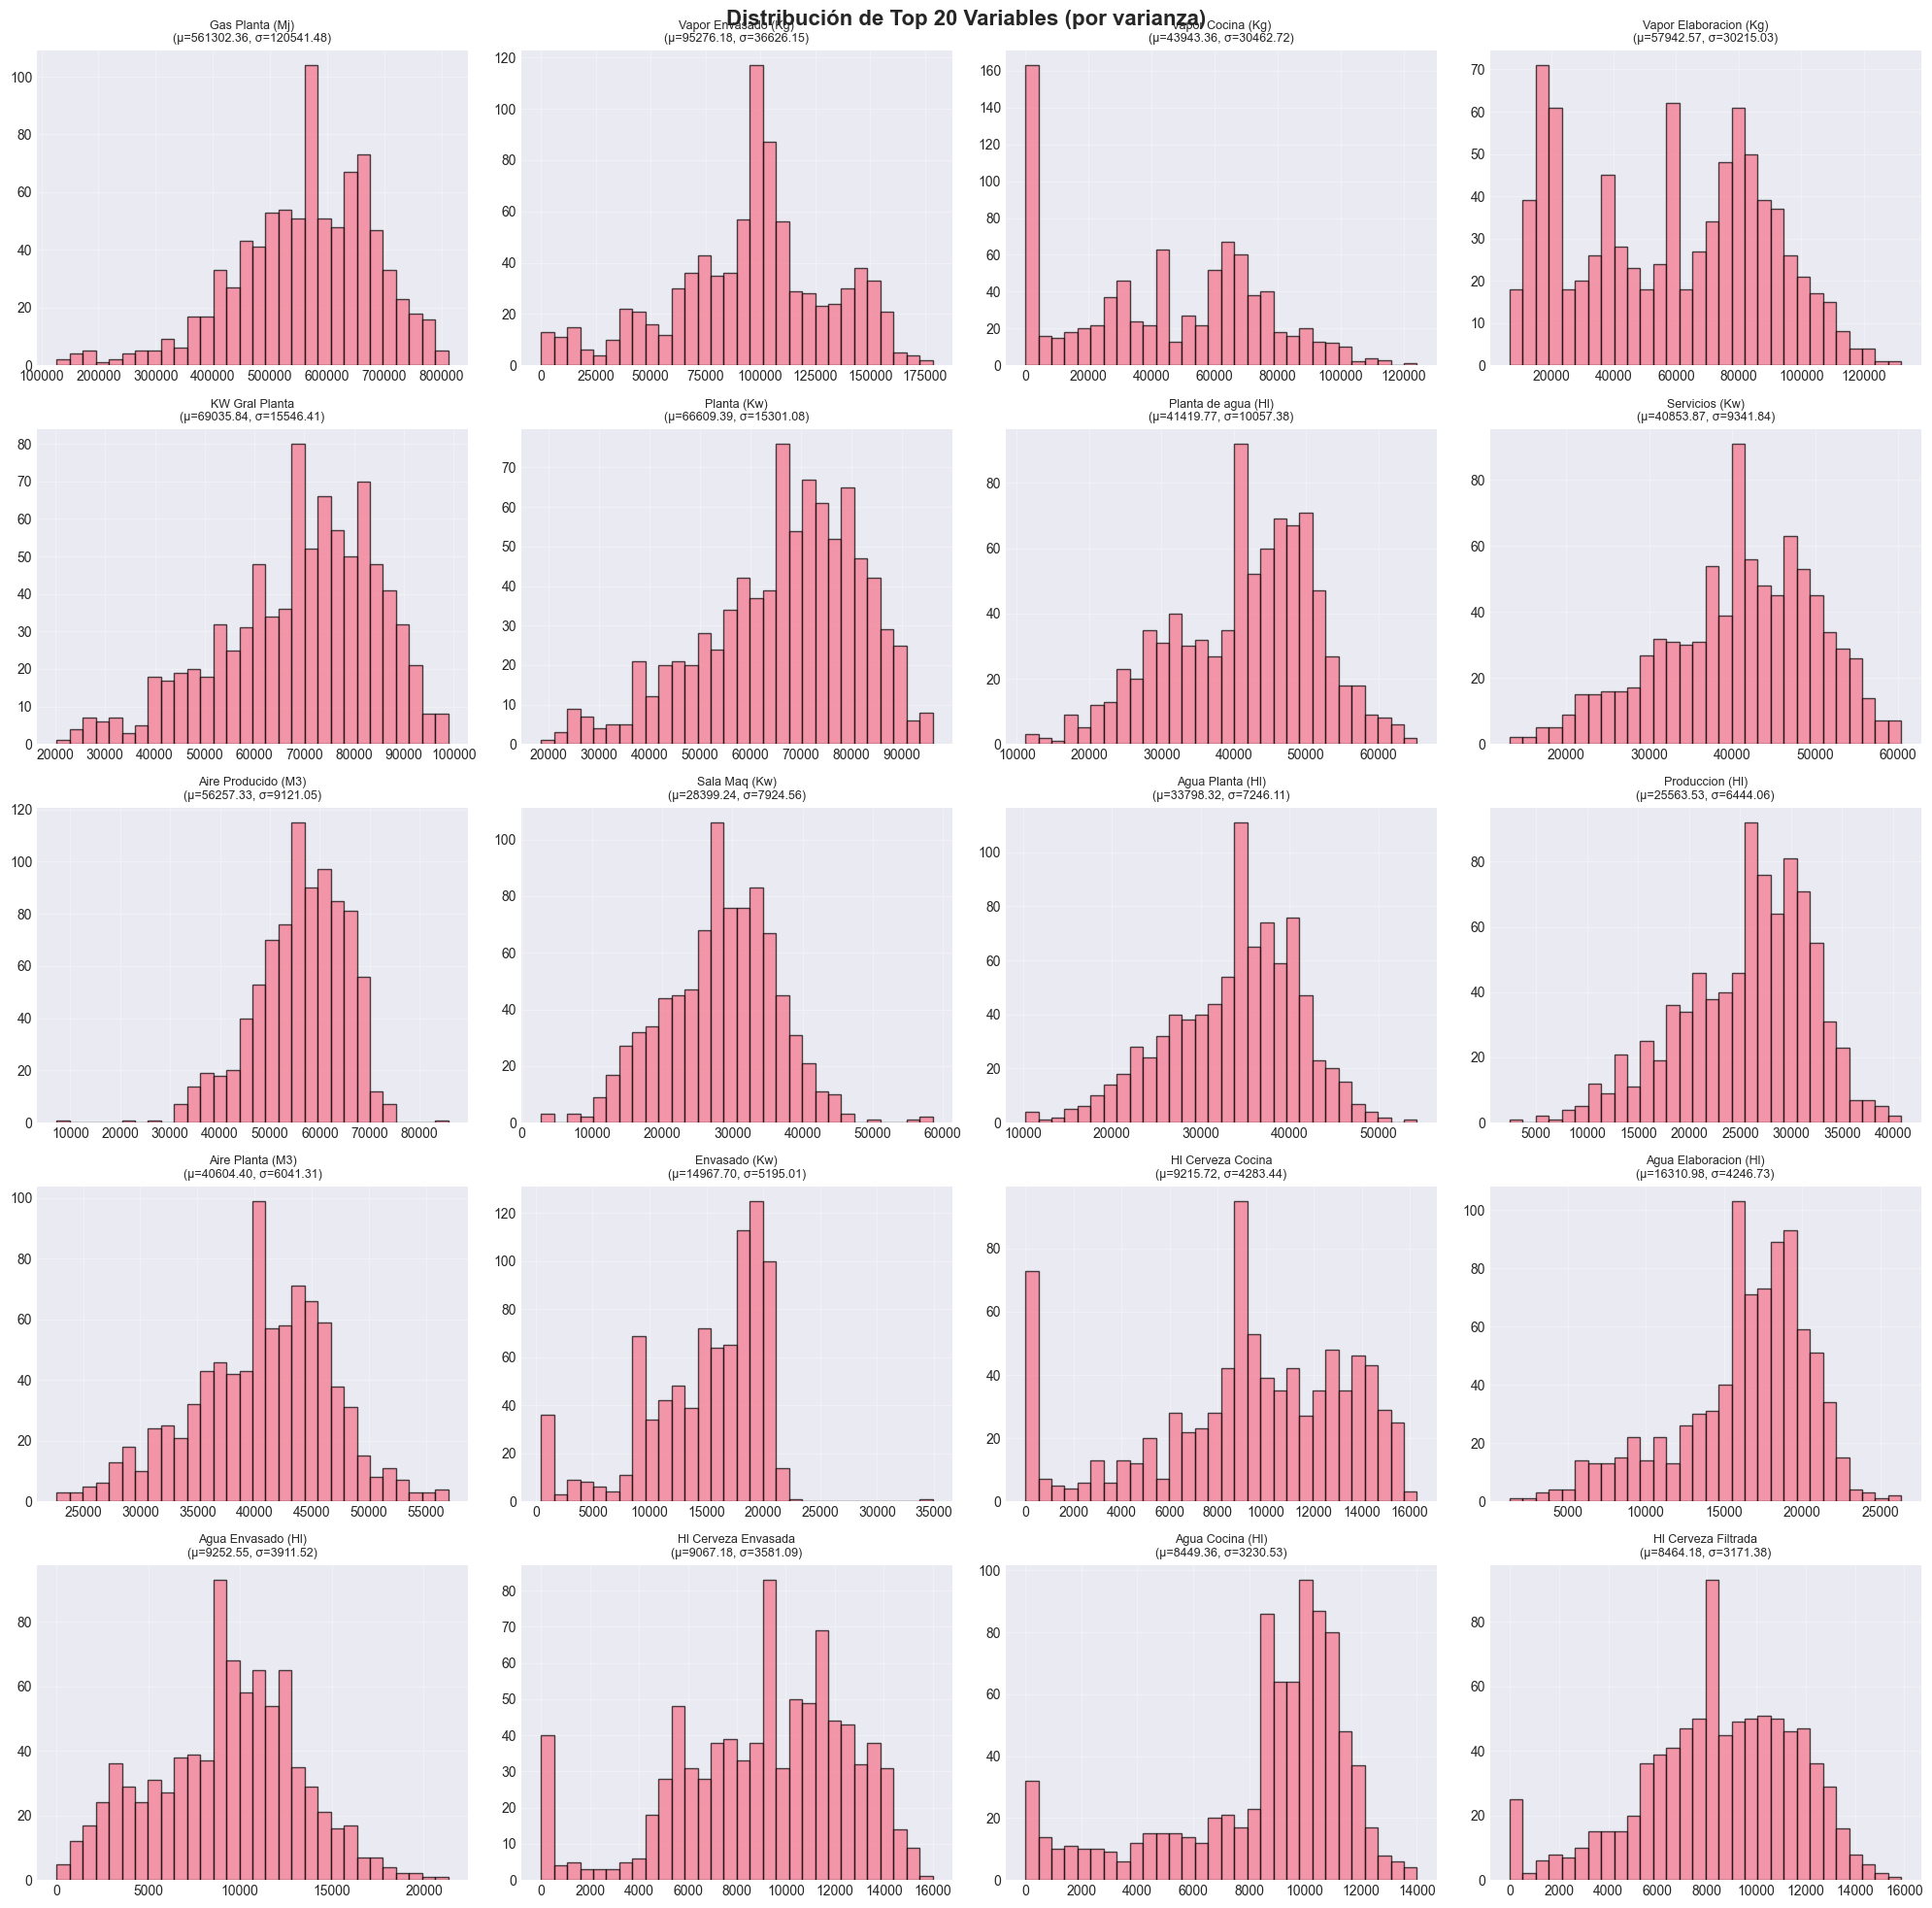


4. ANÁLISIS DE CORRELACIONES


KeyError: 'Frio (Kw)'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 1. ESTADÍSTICAS DESCRIPTIVAS GENERALES
# ============================================================================
print("=" * 80)
print("1. ESTADÍSTICAS DESCRIPTIVAS - TRAIN")
print("=" * 80)

# Estadísticas básicas
desc_stats = train_imputed[numeric_cols].describe()
print("\nEstadísticas básicas:")
print(desc_stats.round(2))

# Información adicional
print("\n" + "=" * 80)
print("INFORMACIÓN ADICIONAL")
print("=" * 80)
print(f"\nShape: {train_imputed.shape}")
print(f"Columnas numéricas: {len(numeric_cols)}")
print(f"Valores nulos: {train_imputed.isna().sum().sum()}")

# Asimetría y curtosis
print("\n" + "-" * 80)
print("ASIMETRÍA (Skewness) Y CURTOSIS")
print("-" * 80)
skew_kurt = pd.DataFrame({
    'Skewness': train_imputed[numeric_cols].skew(),
    'Kurtosis': train_imputed[numeric_cols].kurtosis()
}).round(2)
print(skew_kurt.sort_values('Skewness', ascending=False).head(10))

# ============================================================================
# 2. DISTRIBUCIÓN DE LA VARIABLE OBJETIVO
# ============================================================================
print("\n" + "=" * 80)
print(f"2. ANÁLISIS DE LA VARIABLE OBJETIVO: {target_col}")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Análisis de {target_col}', fontsize=16, fontweight='bold')

# Histograma
axes[0, 0].hist(y_train, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(y_train.mean(), color='red', 
                    linestyle='--', linewidth=2, label=f'Media: {y_train.mean():.2f}')
axes[0, 0].axvline(y_train.median(), color='green', 
                    linestyle='--', linewidth=2, label=f'Mediana: {y_train.median():.2f}')
axes[0, 0].set_xlabel(target_col)
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Histograma')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
bp = axes[0, 1].boxplot(y_train, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
axes[0, 1].set_ylabel(target_col)
axes[0, 1].set_title('Box Plot')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(y_train, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad)')
axes[1, 0].grid(True, alpha=0.3)

# Comparación Train vs Test
axes[1, 1].hist(y_train, bins=30, alpha=0.6, 
                label=f'Train (μ={y_train.mean():.2f})', edgecolor='black')
axes[1, 1].hist(y_test, bins=30, alpha=0.6, 
                label=f'Test (μ={y_test.mean():.2f})', edgecolor='black')
axes[1, 1].set_xlabel(target_col)
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Comparación Train vs Test')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas detalladas del target
print(f"\nEstadísticas de {target_col}:")
print(f"  Media: {y_train.mean():.2f}")
print(f"  Mediana: {y_train.median():.2f}")
print(f"  Desv. Std: {y_train.std():.2f}")
print(f"  Min: {y_train.min():.2f}")
print(f"  Max: {y_train.max():.2f}")
print(f"  Skewness: {y_train.skew():.2f}")
print(f"  Kurtosis: {y_train.kurtosis():.2f}")

# ============================================================================
# 3. DISTRIBUCIÓN DE TODAS LAS VARIABLES NUMÉRICAS
# ============================================================================
print("\n" + "=" * 80)
print("3. DISTRIBUCIÓN DE VARIABLES NUMÉRICAS")
print("=" * 80)

# Seleccionar top 20 variables por varianza
vars_by_variance = train_imputed[numeric_cols].var().sort_values(ascending=False).head(20)
top_vars = vars_by_variance.index.tolist()

n_cols = 4
n_rows = int(np.ceil(len(top_vars) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
fig.suptitle('Distribución de Top 20 Variables (por varianza)', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, col in enumerate(top_vars):
    axes[idx].hist(train_imputed[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}\n(μ={train_imputed[col].mean():.2f}, σ={train_imputed[col].std():.2f})', 
                        fontsize=9)
    axes[idx].set_xlabel('')
    axes[idx].grid(True, alpha=0.3)

# Ocultar ejes vacíos
for idx in range(len(top_vars), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# ============================================================================
# 4. MATRIZ DE CORRELACIÓN
# ============================================================================
print("\n" + "=" * 80)
print("4. ANÁLISIS DE CORRELACIONES")
print("=" * 80)

# Calcular matriz de correlación
corr_matrix = train_imputed[numeric_cols].corr()

# Encontrar las correlaciones más altas con el target
target_corr = corr_matrix[target_col].sort_values(ascending=False)
print(f"\nTop 15 variables más correlacionadas con {target_col}:")
print(target_corr.head(15).round(3))

# Visualizar matriz de correlación (top variables)
top_corr_vars = target_corr.abs().sort_values(ascending=False).head(15).index
corr_subset = train_imputed[top_corr_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title(f'Matriz de Correlación - Top 15 variables correlacionadas con {target_col}', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ============================================================================
# 5. SCATTER PLOTS - RELACIÓN CON VARIABLE OBJETIVO
# ============================================================================
print("\n" + "=" * 80)
print("5. SCATTER PLOTS - RELACIÓN CON TARGET")
print("=" * 80)

# Top 8 variables más correlacionadas (excluyendo el target mismo)
top_predictors = target_corr.drop(target_col).abs().sort_values(ascending=False).head(8).index

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(f'Relación de Variables con {target_col}', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, predictor in enumerate(top_predictors):
    axes[idx].scatter(train_imputed[predictor], y_train, 
                     alpha=0.5, s=20, edgecolors='black', linewidths=0.5)
    
    # Línea de regresión
    z = np.polyfit(train_imputed[predictor], y_train, 1)
    p = np.poly1d(z)
    axes[idx].plot(train_imputed[predictor], p(train_imputed[predictor]), 
                   "r--", linewidth=2, alpha=0.8)
    
    corr_val = train_imputed[[predictor, target_col]].corr().iloc[0, 1]
    axes[idx].set_xlabel(predictor, fontsize=9)
    axes[idx].set_ylabel(target_col, fontsize=9)
    axes[idx].set_title(f'Corr: {corr_val:.3f}', fontsize=10, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. BOX PLOTS COMPARATIVOS
# ============================================================================
print("\n" + "=" * 80)
print("6. BOX PLOTS - COMPARACIÓN DE DISTRIBUCIONES")
print("=" * 80)

# Normalizar datos para comparación visual
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = pd.DataFrame(
    scaler.fit_transform(train_imputed[top_vars]),
    columns=top_vars
)

plt.figure(figsize=(20, 8))
train_scaled.boxplot(rot=90, figsize=(20, 8))
plt.title('Box Plots de Variables Normalizadas (Top 20 por varianza)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Valor Normalizado')
plt.xlabel('Variables')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 7. RESUMEN ESTADÍSTICO POR GRUPOS
# ============================================================================
print("\n" + "=" * 80)
print("7. RESUMEN FINAL")
print("=" * 80)

# Crear tabla resumen
summary_table = pd.DataFrame({
    'Media': train_imputed[numeric_cols].mean(),
    'Mediana': train_imputed[numeric_cols].median(),
    'Std': train_imputed[numeric_cols].std(),
    'Min': train_imputed[numeric_cols].min(),
    'Max': train_imputed[numeric_cols].max(),
    'Skew': train_imputed[numeric_cols].skew(),
    'Corr_Target': corr_matrix[target_col]
}).round(3)

summary_table = summary_table.sort_values('Corr_Target', key=abs, ascending=False)

print("\nTop 15 variables por correlación absoluta con target:")
print(summary_table.head(15))

print("\n" + "=" * 80)
print("✓ ANÁLISIS EXPLORATORIO COMPLETADO")
print("=" * 80)